##### Copyright 2021 The Cirq Developers

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/noise/qcvv/isolated_xeb"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/noise/qcvv/isolated_xeb.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/noise/qcvv/isolated_xeb.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/noise/qcvv/isolated_xeb.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

installing cirq...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<4.22,>=4.21.6; python_version < "3.11", but you have protobuf 5.29.5 which is incompatible.


installed cirq.


# Isolated XEB

This notebook demonstrates how to use the functionality in `cirq.experiments` to run Isolated XEB end-to-end. "Isolated" means we do one pair of qubits at a time.

In [3]:
import cirq
import numpy as np

## Set up Random Circuits

We create a library of 20 random, two-qubit `circuits` using the sqrt(ISWAP) gate on the two qubits we've chosen.

In [4]:
from cirq.experiments import random_quantum_circuit_generation as rqcg

circuits = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20,
    two_qubit_gate=cirq.ISWAP**0.5,
    q0=cirq.GridQubit(4, 4),
    q1=cirq.GridQubit(4, 5),
)
print(len(circuits))

20


In [5]:
# We will truncate to these lengths
max_depth = 100
cycle_depths = np.arange(3, max_depth, 20)
cycle_depths

array([ 3, 23, 43, 63, 83])

### Set up a `Sampler`.

For demonstration, we'll use a density matrix simulator to sample noisy samples. However, input a `device_name` (and have an authenticated Google Cloud project name set as your `GOOGLE_CLOUD_PROJECT` environment variable) to run on a real device.

In [6]:
device_name = None  # change me!

if device_name is None:
    sampler = cirq.DensityMatrixSimulator(noise=cirq.depolarize(5e-3))
else:
    import cirq_google as cg

    sampler = cg.get_engine_sampler(device_name, gate_set_name='sqrt_iswap')
    device = cg.get_engine_device(device_name)

    import cirq.contrib.routing as ccr

    graph = ccr.gridqubits_to_graph_device(device.qubits)
    pos = {q: (q.row, q.col) for q in graph.nodes}
    import networkx as nx

    nx.draw_networkx(graph, pos=pos)

## Take Data

In [7]:
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits

sampled_df = sample_2q_xeb_circuits(
    sampler=sampler, circuits=circuits, cycle_depths=cycle_depths, repetitions=10_000
)
sampled_df

  0%|          | 0/108 [00:00<?, ?it/s]

  8%|▊         | 9/108 [00:00<00:04, 20.75it/s]

 17%|█▋        | 18/108 [00:00<00:03, 24.58it/s]

 25%|██▌       | 27/108 [00:01<00:05, 14.54it/s]

 33%|███▎      | 36/108 [00:02<00:06, 11.31it/s]

 42%|████▏     | 45/108 [00:04<00:06,  9.28it/s]

 50%|█████     | 54/108 [00:05<00:07,  7.42it/s]

 58%|█████▊    | 63/108 [00:07<00:06,  6.45it/s]

 67%|██████▋   | 72/108 [00:09<00:06,  5.35it/s]

 75%|███████▌  | 81/108 [00:12<00:05,  4.73it/s]

 83%|████████▎ | 90/108 [00:15<00:04,  4.05it/s]

 92%|█████████▏| 99/108 [00:17<00:02,  3.75it/s]

100%|██████████| 108/108 [00:18<00:00,  5.10it/s]

100%|██████████| 108/108 [00:18<00:00,  5.93it/s]

sampled_probs     timestamp  \
circuit_i cycle_depth                                                   
0         3            [0.4475, 0.1613, 0.2565, 0.1347]  1.748601e+09   
1         3            [0.1757, 0.1558, 0.6124, 0.0561]  1.748601e+09   
2         3             [0.5577, 0.137, 0.0355, 0.2698]  1.748601e+09   
3         3            [0.4909, 0.0619, 0.3096, 0.1376]  1.748601e+09   
4         3             [0.039, 0.2137, 0.1022, 0.6451]  1.748601e+09   
...                                                 ...           ...   
15        83             [0.2616, 0.2508, 0.2176, 0.27]  1.748601e+09   
16        83            [0.2234, 0.298, 0.2231, 0.2555]  1.748601e+09   
17        83            [0.2322, 0.2576, 0.2842, 0.226]  1.748601e+09   
18        83            [0.2863, 0.2383, 0.242, 0.2334]  1.748601e+09   
19        83           [0.2162, 0.2179, 0.3538, 0.2121]  1.748601e+09   

                                     pair  
circuit_i cycle_depth                      
0         3            (q(4, 4), q(4, 5))  
1         3            (q(4, 4), q(4, 5))  
2         3            (q(4, 4), q(4, 5))  
3         3            (q(4, 4), q(4, 5))  
4         3            (q(4, 4), q(4, 5))  
...                                   ...  
15        83           (q(4, 4), q(4, 5))  
16        83           (q(4, 4), q(4, 5))  
17        83           (q(4, 4), q(4, 5))  
18        83           (q(4, 4), q(4, 5))  
19        83           (q(4, 4), q(4, 5))  

[100 rows x 3 columns]

## Benchmark fidelities

In [8]:
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities

fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df, circuits=circuits, cycle_depths=cycle_depths
)
fids

cycle_depth  fidelity  fidelity_variance                pair
0            3  0.927771           0.161473  (q(4, 4), q(4, 5))
1           23  0.603447           0.140176  (q(4, 4), q(4, 5))
2           43  0.384936           0.151169  (q(4, 4), q(4, 5))
3           63  0.255904           0.150423  (q(4, 4), q(4, 5))
4           83  0.172789           0.183794  (q(4, 4), q(4, 5))

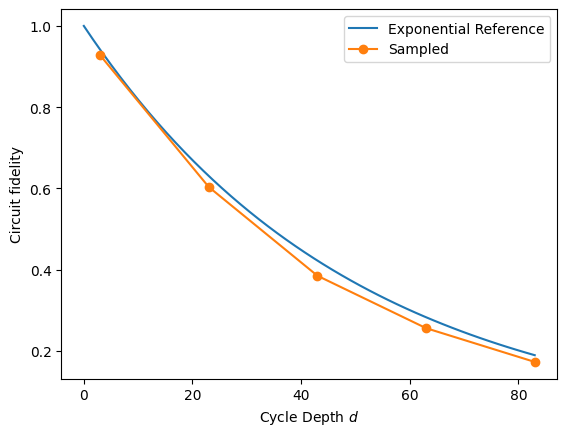

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

# Exponential reference
xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1 - 5e-3) ** (4 * xx), label=r'Exponential Reference')


def _p(fids):
    plt.plot(fids['cycle_depth'], fids['fidelity'], 'o-', label=fids.name)


fids.name = 'Sampled'
_p(fids)

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth $d$')
plt.legend(loc='best')

## Optimize `PhasedFSimGate` parameters

We know what circuits we requested, and in this simulated example, we know what coherent error has happened. But in a real experiment, there is likely unknown coherent error that you would like to characterize. Therefore, we make the five angles in `PhasedFSimGate` free parameters and use a classical optimizer to find which set of parameters best describes the data we collected from the noisy simulator (or device, if this was a real experiment).

In [10]:
import multiprocessing

pool = multiprocessing.get_context('spawn').Pool()

In [11]:
from cirq.experiments.xeb_fitting import (
    parameterize_circuit,
    characterize_phased_fsim_parameters_with_xeb,
    SqrtISwapXEBOptions,
)

# Set which angles we want to characterize (all)
options = SqrtISwapXEBOptions(
    characterize_theta=True,
    characterize_zeta=True,
    characterize_chi=True,
    characterize_gamma=True,
    characterize_phi=True,
)
# Parameterize the sqrt(iswap)s in our circuit library
pcircuits = [parameterize_circuit(circuit, options) for circuit in circuits]

# Run the characterization loop
characterization_result = characterize_phased_fsim_parameters_with_xeb(
    sampled_df,
    pcircuits,
    cycle_depths,
    options,
    pool=pool,
    # ease tolerance so it converges faster:
    fatol=5e-3,
    xatol=5e-3,
)

Simulating with theta =  -0.785 zeta  =       0 chi   =       0 gamma =       0 phi   =       0 


Loss:   0.531


Simulating with theta =  -0.685 zeta  =       0 chi   =       0 gamma =       0 phi   =       0 


Loss:   0.581


Simulating with theta =  -0.785 zeta  =     0.1 chi   =       0 gamma =       0 phi   =       0 
Loss:   0.564


Simulating with theta =  -0.785 zeta  =       0 chi   =     0.1 gamma =       0 phi   =       0 


Loss:   0.553


Simulating with theta =  -0.785 zeta  =       0 chi   =       0 gamma =     0.1 phi   =       0 


Loss:   0.595


Simulating with theta =  -0.785 zeta  =       0 chi   =       0 gamma =       0 phi   =     0.1 


Loss:   0.564


Simulating with theta =  -0.745 zeta  =    0.04 chi   =    0.04 gamma =    -0.1 phi   =    0.04 


Loss:    0.61


Simulating with theta =  -0.775 zeta  =    0.01 chi   =    0.01 gamma =    0.05 phi   =    0.01 


Loss:   0.554


Simulating with theta =  -0.881 zeta  =   0.044 chi   =   0.044 gamma =    0.02 phi   =   0.044 


Loss:   0.601


Simulating with theta =  -0.734 zeta  =   0.011 chi   =   0.011 gamma =   0.005 phi   =   0.011 


Loss:   0.543


Simulating with theta =  -0.761 zeta  =  0.0484 chi   =  0.0484 gamma =   0.022 phi   = -0.0916 


Loss:   0.572


Simulating with theta =  -0.779 zeta  =  0.0121 chi   =  0.0121 gamma =  0.0055 phi   =  0.0521 


Loss:   0.544


Simulating with theta =  -0.759 zeta  = -0.0868 chi   =  0.0532 gamma =  0.0242 phi   =  0.0292 


Loss:   0.578


Simulating with theta =  -0.779 zeta  =  0.0533 chi   =  0.0133 gamma = 0.00605 phi   = 0.00731 


Loss:   0.539


Simulating with theta =   -0.77 zeta  =  0.0206 chi   =  0.0446 gamma = -0.0434 phi   =  0.0182 


Loss:   0.551


Simulating with theta =  -0.754 zeta  =  0.0388 chi   = -0.0676 gamma = -0.0107 phi   =  0.0354 


Loss:   0.564


Simulating with theta =  -0.777 zeta  =  0.0097 chi   =  0.0581 gamma = -0.00268 phi   = 0.00886 


Loss:   0.535


Simulating with theta =  -0.772 zeta  =  0.0139 chi   = -0.00676 gamma =  0.0489 phi   =  0.0135 


Loss:   0.559


Simulating with theta =   -0.77 zeta  =  0.0189 chi   =  0.0317 gamma = -0.0203 phi   =   0.017 


Loss:   0.534


Simulating with theta =  -0.759 zeta  =  0.0251 chi   =  0.0336 gamma = -0.0103 phi   = -0.0344 


Loss:    0.55


Simulating with theta =  -0.774 zeta  =  0.0153 chi   =  0.0175 gamma = 0.00156 phi   =  0.0305 


Loss:   0.534


Simulating with theta =   -0.82 zeta  =  0.0279 chi   =  0.0372 gamma = -0.0112 phi   =  0.0145 


Loss:   0.548


Simulating with theta =  -0.756 zeta  =  0.0152 chi   =  0.0176 gamma = 0.000962 phi   =  0.0119 


Loss:   0.533


Simulating with theta =  -0.767 zeta  = -0.0296 chi   =  0.0366 gamma = -0.0142 phi   =    0.02 


Loss:   0.536


Simulating with theta =   -0.77 zeta  = -0.00891 chi   =  0.0308 gamma = -0.00917 phi   =  0.0168 


Loss:   0.531


Simulating with theta =  -0.765 zeta  = 0.00652 chi   = -0.0191 gamma = -0.0081 phi   =  0.0216 


Loss:   0.537


Simulating with theta =  -0.774 zeta  =  0.0089 chi   =  0.0388 gamma = -0.00404 phi   =   0.012 


Loss:   0.531


Simulating with theta =  -0.773 zeta  = -0.00667 chi   =  0.0101 gamma =   0.016 phi   =  0.0115 


Loss:   0.533


Simulating with theta =  -0.769 zeta  = -0.0119 chi   =  0.0215 gamma = -4.04e-05 phi   = -0.0096 


Loss:   0.529


Simulating with theta =  -0.767 zeta  = -0.0256 chi   =  0.0234 gamma = -0.000839 phi   = -0.0296 


Loss:   0.533


Simulating with theta =  -0.768 zeta  = 0.00799 chi   =  0.0333 gamma = -0.0209 phi   = 0.000983 


Loss:   0.536


Simulating with theta =  -0.772 zeta  =  -0.003 chi   =  0.0159 gamma = 0.00679 phi   = 0.00884 


Loss:    0.53


Simulating with theta =  -0.792 zeta  = -0.0212 chi   =  0.0252 gamma = -0.00354 phi   = -0.000627 


Loss:   0.533


Simulating with theta =  -0.765 zeta  = 0.00612 chi   =  0.0195 gamma = -0.000165 phi   = 0.00874 


Loss:    0.53


Simulating with theta =  -0.777 zeta  = 0.00895 chi   = 0.00746 gamma =  0.0102 phi   = -0.00879 


Loss:   0.529


Simulating with theta =   -0.78 zeta  =  0.0179 chi   = -0.00421 gamma =  0.0199 phi   = -0.0216 


Loss:   0.531


Simulating with theta =  -0.757 zeta  = 0.00362 chi   =  0.0412 gamma = 0.00509 phi   =  0.0045 


Loss:   0.532


Simulating with theta =  -0.778 zeta  = 0.000905 chi   =  0.0103 gamma = 0.00127 phi   = 0.00112 


Loss:   0.529


Simulating with theta =   -0.77 zeta  = -0.00848 chi   = -0.00896 gamma =  0.0113 phi   = -0.0119 


Loss:   0.533


Simulating with theta =  -0.773 zeta  = 0.00456 chi   =  0.0269 gamma = -0.000214 phi   = 0.00605 
Loss:   0.529


Simulating with theta =  -0.773 zeta  = 0.00645 chi   =  0.0183 gamma = -0.00237 phi   = -0.00983 


Loss:   0.529


Simulating with theta =  -0.783 zeta  = -0.00254 chi   =  0.0143 gamma =  0.0037 phi   = -0.0172 


Loss:   0.528


Simulating with theta =  -0.792 zeta  = -0.00688 chi   =  0.0117 gamma = 0.00563 phi   = -0.0301 


Loss:    0.53


Simulating with theta =  -0.785 zeta  =  0.0192 chi   = 0.00944 gamma = 0.00507 phi   = -0.00184 


Loss:    0.53


Simulating with theta =  -0.773 zeta  = -0.00413 chi   =  0.0184 gamma = 0.00124 phi   = -0.00766 


Loss:   0.528


Simulating with theta =  -0.773 zeta  = 0.00441 chi   =  0.0238 gamma = 0.00374 phi   = -0.0161 


Loss:   0.528

Simulating with theta =  -0.771 zeta  = 0.00616 chi   =  0.0306 gamma = 0.00497 phi   = -0.0247 


Loss:   0.529


Simulating with theta =  -0.779 zeta  = -0.00195 chi   =   0.018 gamma = 0.00983 phi   = -0.00762 
Loss:   0.528


Simulating with theta =  -0.782 zeta  = -0.00615 chi   =  0.0179 gamma =  0.0159 phi   = -0.00652 


Loss:   0.529


Simulating with theta =  -0.781 zeta  = -0.00266 chi   = 0.00596 gamma =  0.0117 phi   =  -0.029 


Loss:   0.528

Simulating with theta =  -0.779 zeta  = -0.0117 chi   =  0.0248 gamma = 0.00189 phi   = -0.0222 


Loss:   0.529


Simulating with theta =  -0.778 zeta  = -0.00654 chi   =  0.0204 gamma = 0.00396 phi   = -0.0189 


Loss:   0.528


Simulating with theta =  -0.785 zeta  = 0.000411 chi   =  0.0146 gamma =  0.0119 phi   = -0.0278 


Loss:   0.527


Simulating with theta =  -0.791 zeta  = 0.00268 chi   =  0.0126 gamma =  0.0173 phi   = -0.0379 


Loss:   0.528


Simulating with theta =  -0.779 zeta  = 0.000178 chi   =  0.0305 gamma = 0.00158 phi   = -0.00603 


Loss:   0.528


Simulating with theta =  -0.774 zeta  = 0.00115 chi   =  0.0287 gamma = 0.00872 phi   = -0.0134 


Loss:   0.527


Simulating with theta =  -0.777 zeta  = -0.00119 chi   =  0.0117 gamma =  0.0137 phi   = -0.0275 


Loss:   0.528


Simulating with theta =  -0.784 zeta  = -0.00766 chi   =  0.0136 gamma =  0.0155 phi   =  -0.022 


Loss:   0.528


Simulating with theta =  -0.781 zeta  = 0.00284 chi   =  0.0142 gamma =  0.0199 phi   = -0.0205 


Loss:   0.527


Simulating with theta =  -0.782 zeta  = 0.000175 chi   =   0.015 gamma =  0.0181 phi   = -0.0368 


Loss:   0.527


Simulating with theta =  -0.783 zeta  = 0.00124 chi   =  0.0135 gamma =  0.0222 phi   = -0.0515 


Loss:   0.528


Simulating with theta =  -0.776 zeta  = 0.00901 chi   =  0.0201 gamma =  0.0134 phi   = -0.0284 


Loss:   0.527


Simulating with theta =  -0.782 zeta  = 0.00662 chi   =  0.0253 gamma =  0.0151 phi   = -0.0233 


Loss:   0.527


Simulating with theta =  -0.784 zeta  =  0.0105 chi   =  0.0321 gamma =  0.0158 phi   = -0.0212 


Loss:   0.527


Simulating with theta =  -0.786 zeta  = -0.00453 chi   =   0.019 gamma =  0.0161 phi   = -0.0203 


Loss:   0.527


Simulating with theta =  -0.782 zeta  = -0.00131 chi   =  0.0269 gamma = 0.00807 phi   = -0.0282 


Loss:   0.528


Simulating with theta =  -0.782 zeta  =  0.0018 chi   =  0.0174 gamma =   0.017 phi   = -0.0224 


Loss:   0.527


Simulating with theta =  -0.792 zeta  = 0.000646 chi   = 0.00784 gamma =  0.0226 phi   = -0.0389 


Loss:   0.528


Simulating with theta =  -0.779 zeta  = 0.00102 chi   =  0.0235 gamma =  0.0122 phi   = -0.0198 


Loss:   0.527


Simulating with theta =  -0.779 zeta  = 0.00163 chi   =  0.0255 gamma =  0.0194 phi   = -0.0212 


Loss:   0.527


Simulating with theta =  -0.777 zeta  = 0.00223 chi   =   0.031 gamma =  0.0232 phi   =  -0.018 


Loss:   0.527


Simulating with theta =  -0.775 zeta  = 0.00903 chi   =  0.0237 gamma =  0.0166 phi   = -0.0291 


Loss:   0.527


Simulating with theta =  -0.778 zeta  = 0.00564 chi   =  0.0225 gamma =  0.0165 phi   = -0.0269 


Loss:   0.527


Simulating with theta =  -0.778 zeta  = 0.00651 chi   =  0.0306 gamma =   0.014 phi   = -0.00861 


Loss:   0.528


Simulating with theta =  -0.781 zeta  = 0.00176 chi   =  0.0189 gamma =  0.0171 phi   = -0.0298 


Loss:   0.527


Simulating with theta =  -0.778 zeta  = 0.00486 chi   =  0.0289 gamma =  0.0152 phi   =  -0.026 


Loss:   0.527


Simulating with theta =   -0.78 zeta  = 0.00718 chi   =   0.025 gamma =  0.0211 phi   = -0.0311 


Loss:   0.526


Simulating with theta =  -0.781 zeta  =  0.0103 chi   =  0.0258 gamma =  0.0256 phi   = -0.0368 


Loss:   0.527


Simulating with theta =  -0.777 zeta  = 0.00181 chi   =   0.023 gamma =  0.0206 phi   = -0.0307 


Loss:   0.526


Simulating with theta =  -0.774 zeta  = -0.000604 chi   =  0.0219 gamma =  0.0233 phi   = -0.0344 


Loss:   0.527


Simulating with theta =   -0.78 zeta  = 0.00234 chi   =  0.0171 gamma =  0.0227 phi   = -0.0299 


Loss:   0.527


Simulating with theta =  -0.781 zeta  = 0.000245 chi   =  0.0213 gamma =  0.0239 phi   = -0.0302 


Loss:   0.526


Simulating with theta =  -0.783 zeta  = -0.00245 chi   =  0.0207 gamma =  0.0276 phi   = -0.0318 


Loss:   0.526


Simulating with theta =   -0.78 zeta  = 0.00371 chi   =  0.0166 gamma =  0.0227 phi   = -0.0395 


Loss:   0.527


Simulating with theta =   -0.78 zeta  = 0.00215 chi   =  0.0233 gamma =  0.0203 phi   = -0.0258 


Loss:   0.526


Simulating with theta =  -0.779 zeta  = 0.00291 chi   =  0.0276 gamma =  0.0185 phi   = -0.0291 


Loss:   0.526


Simulating with theta =  -0.778 zeta  = 0.00396 chi   =  0.0292 gamma =  0.0247 phi   =  -0.029 


Loss:   0.526


Simulating with theta =  -0.779 zeta  = 0.00341 chi   =  0.0266 gamma =  0.0228 phi   = -0.0292 


Loss:   0.526


Simulating with theta =  -0.778 zeta  = -0.00298 chi   =  0.0237 gamma =  0.0212 phi   = -0.0269 


Loss:   0.526


Simulating with theta =  -0.778 zeta  = -0.000436 chi   =   0.024 gamma =  0.0212 phi   =  -0.028 


Loss:   0.526


In [12]:
characterization_result.final_params

{(cirq.GridQubit(4, 4),
  cirq.GridQubit(4, 5)): {'theta': np.float64(-0.7783379736657015), 'zeta': np.float64(-0.00043573822845567947), 'chi': np.float64(0.0240391542895369), 'gamma': np.float64(0.021218997340166138), 'phi': np.float64(-0.027952516833367733)}}

In [13]:
characterization_result.fidelities_df

cycle_depth  fidelity  fidelity_variance                pair
0            3  0.936075           0.166842  (q(4, 4), q(4, 5))
1           23  0.612905           0.150976  (q(4, 4), q(4, 5))
2           43  0.383920           0.156385  (q(4, 4), q(4, 5))
3           63  0.259745           0.173207  (q(4, 4), q(4, 5))
4           83  0.175707           0.212425  (q(4, 4), q(4, 5))

In [14]:
from cirq.experiments.xeb_fitting import before_and_after_characterization

before_after_df = before_and_after_characterization(fids, characterization_result)
before_after_df

a_0  layer_fid_0       cycle_depths_0  \
pair                                                             
(q(4, 4), q(4, 5))  0.988384     0.978728  [3, 23, 43, 63, 83]   

                                                         fidelities_0  \
pair                                                                    
(q(4, 4), q(4, 5))  [0.9277707576109281, 0.6034474735321084, 0.384...   

                     a_std_0  \
pair                           
(q(4, 4), q(4, 5))  0.006207   

                                                      layer_fid_std_0  \
pair                                                                    
(q(4, 4), q(4, 5))  [0.40183770462121454, 0.3744005241786973, 0.38...   

                         a_c  layer_fid_c       cycle_depths_c  \
pair                                                             
(q(4, 4), q(4, 5))  0.998019     0.978734  [3, 23, 43, 63, 83]   

                                                         fidelities_c  \
pair                                                                    
(q(4, 4), q(4, 5))  [0.9360748893403936, 0.6129045406059934, 0.383...   

                     a_std_c  \
pair                           
(q(4, 4), q(4, 5))  0.009444   

                                                      layer_fid_std_c  \
pair                                                                    
(q(4, 4), q(4, 5))  [0.4084634927754985, 0.388556097934968, 0.3954...   

                                                 characterized_angles  \
pair                                                                    
(q(4, 4), q(4, 5))  {'theta': -0.7783379736657015, 'zeta': -0.0004...   

                       theta      zeta       chi     gamma       phi  
pair                                                                  
(q(4, 4), q(4, 5)) -0.778338 -0.000436  0.024039  0.021219 -0.027953

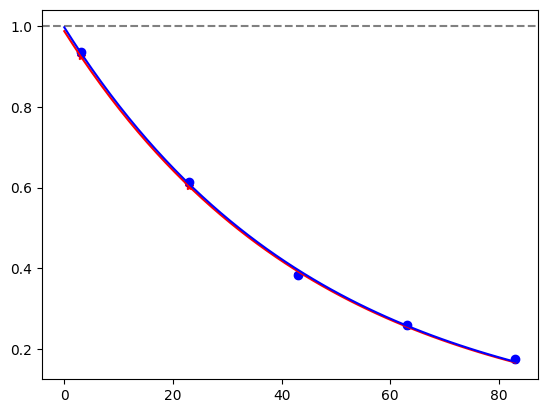

In [15]:
from cirq.experiments.xeb_fitting import exponential_decay

for i, row in before_after_df.iterrows():
    plt.axhline(1, color='grey', ls='--')
    plt.plot(row['cycle_depths_0'], row['fidelities_0'], '*', color='red')
    plt.plot(row['cycle_depths_c'], row['fidelities_c'], 'o', color='blue')

    xx = np.linspace(0, np.max(row['cycle_depths_0']))
    plt.plot(xx, exponential_decay(xx, a=row['a_0'], layer_fid=row['layer_fid_0']), color='red')
    plt.plot(xx, exponential_decay(xx, a=row['a_c'], layer_fid=row['layer_fid_c']), color='blue')

    plt.show()